# Прекод

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные лежат в папке `/datasets/image_search/`.



В папке `train_images` содержатся изображения для тренировки модели.







В папке `test_images` содержатся изображения для тестирования модели.

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке: 

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке. 
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


In [1]:
import pandas as pd
import torch.nn as nn
from PIL import Image
import torchvision.models as models
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
import re
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm
import torch
import numpy as np

nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\qwe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\qwe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

In [2]:
crowd = pd.read_csv(url, sep=('\t'), names=[1,2,'crowd_sum',4,5])
crowd

,1,2,crowd_sum,4,5
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.000000,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.000000,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.000000,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.000000,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.000000,0,3
...,...,...,...,...,...
47825,997722733_0cb5439472.jpg,543007912_23fc735b99.jpg#2,0.000000,0,3
47826,997722733_0cb5439472.jpg,544576742_283b65fa0d.jpg#2,0.333333,1,2
47827,997722733_0cb5439472.jpg,872622575_ba1d3632cc.jpg#2,1.000000,3,0
47828,997722733_0cb5439472.jpg,888425986_e4b6c12324.jpg#2,0.000000,0,3


В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

In [3]:
expert = pd.read_csv(url, sep=('\t'), names=[1,2,3,4,5])

Приведу результат опроса экспертов к результату краудсорсинга. Если эксперт ставит больше 2, то запрос соответствует тексту(оценка равна 1), суммирую оценки и делю на 3.

In [4]:
expert['expert_sum'] = ((expert.loc[:,3] > 2).astype('int')+(expert.loc[:,4] > 2).astype('int')+(expert.loc[:,5] > 2).astype('int')) /3

In [5]:
expert

,1,2,3,4,5,expert_sum
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,0.0
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,0.0
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2,0.0
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2,0.0
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2,0.0
...,...,...,...,...,...,...
5817,997722733_0cb5439472.jpg,2981702521_2459f2c1c4.jpg#2,1,1,1,0.0
5818,997722733_0cb5439472.jpg,2985679744_75a7102aab.jpg#2,1,1,1,0.0
5819,997722733_0cb5439472.jpg,3150742439_b8a352e1e0.jpg#2,1,1,2,0.0
5820,997722733_0cb5439472.jpg,3375070563_3c290a7991.jpg#2,1,1,1,0.0


In [6]:
df = pd.merge(crowd, expert, left_on=[1,2], right_on=[1,2], how='outer')[[1,2,'expert_sum','crowd_sum']]
df.crowd_sum = df.crowd_sum.fillna(df.expert_sum)
df.expert_sum = df.expert_sum.fillna(df.crowd_sum)
df

,1,2,expert_sum,crowd_sum
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,1.0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0.0
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0.0
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0.0
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0.0
...,...,...,...,...
51318,997722733_0cb5439472.jpg,2641770481_c98465ff35.jpg#2,0.0,0.0
51319,997722733_0cb5439472.jpg,2932740428_b15384f389.jpg#2,0.0,0.0
51320,997722733_0cb5439472.jpg,2968182121_b3b491df85.jpg#2,0.0,0.0
51321,997722733_0cb5439472.jpg,2981702521_2459f2c1c4.jpg#2,0.0,0.0


Дам больше веса мнению экспертов 70%.

In [7]:
df['fin_sum'] = (df.expert_sum * 0.7) + (df.crowd_sum * 0.3)

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

In [8]:
df_all = df.drop(['expert_sum','crowd_sum'], axis=1).copy()

In [9]:
train = pd.read_csv(url)
train

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
...,...,...,...
5817,757046028_ff5999f91b.jpg,2061144717_5b3a1864f0.jpg#2,A man in an ampitheater talking to a boy .
5818,799486353_f665d7b0f0.jpg,2196107384_361d73a170.jpg#2,a old man walks down the uncrowded road .
5819,909808296_23c427022d.jpg,2112921744_92bf706805.jpg#2,A dog stands on the side of a grassy cliff .
5820,929679367_ff8c7df2ee.jpg,3651971126_309e6a5e22.jpg#2,A blurry photo of two dogs .


In [10]:
train.describe()

,image,query_id,query_text
count,5822,5822,5822
unique,1000,977,977
top,3364151356_eecd07a23e.jpg,2600867924_cd502fc911.jpg#2,"Two dogs , one brown and white and one black a..."
freq,10,34,34


In [11]:
df_all

,1,2,fin_sum
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0
...,...,...,...
51318,997722733_0cb5439472.jpg,2641770481_c98465ff35.jpg#2,0.0
51319,997722733_0cb5439472.jpg,2932740428_b15384f389.jpg#2,0.0
51320,997722733_0cb5439472.jpg,2968182121_b3b491df85.jpg#2,0.0
51321,997722733_0cb5439472.jpg,2981702521_2459f2c1c4.jpg#2,0.0


In [12]:
df_all = pd.merge(df_all, train[['query_id','query_text']].drop_duplicates(), left_on=[2], right_on=['query_id'])[[1,'query_text', 'fin_sum']]
df_all['img'] = 'train'
df_all

,1,query_text,fin_sum,img
0,1056338697_4f7d7ce270.jpg,"A woman is signaling is to traffic , as seen f...",1.000000,train
1,2182488373_df73c7cc09.jpg,"A woman is signaling is to traffic , as seen f...",0.000000,train
2,2594042571_2e4666507e.jpg,"A woman is signaling is to traffic , as seen f...",0.000000,train
3,2843695880_eeea6c67db.jpg,"A woman is signaling is to traffic , as seen f...",0.000000,train
4,2892995070_39f3c9a56e.jpg,"A woman is signaling is to traffic , as seen f...",0.000000,train
...,...,...,...,...
50209,422763475_0bc814dac6.jpg,a snowboarder,0.333333,train
50210,96420612_feb18fc6c6.jpg,a snowboarder,0.000000,train
50211,2985679744_75a7102aab.jpg,a snowboarder,0.000000,train
50212,3745451546_fc8ec70cbd.jpg,a snowboarder,0.000000,train


In [13]:
train[['query_id','query_text']].drop_duplicates()

,query_id,query_text
0,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
12,2718495608_d8533e3ac5.jpg#2,A girl wearing a yellow shirt and sunglasses s...
22,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .
27,3207358897_bfa61fa3c6.jpg#2,A woman plays with long red ribbons in an empt...
31,3286822339_5535af6b93.jpg#2,Chinese market street in the winter time .
...,...,...
5817,2061144717_5b3a1864f0.jpg#2,A man in an ampitheater talking to a boy .
5818,2196107384_361d73a170.jpg#2,a old man walks down the uncrowded road .
5819,2112921744_92bf706805.jpg#2,A dog stands on the side of a grassy cliff .
5820,3651971126_309e6a5e22.jpg#2,A blurry photo of two dogs .


В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

In [14]:
test_queries = pd.read_csv('to_upload/test_queries.csv', sep='|', index_col=0)

In [15]:
test_queries.describe()

,query_id,query_text,image
count,500,500,500
unique,500,500,100
top,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
freq,1,1,5


### Вывод
  - Количество уникальных изображений в обучающем наборе равно 1000, а в тестовом 500.
  - Количество уникальных запросов в обучающем наборе равно 977, а в тестовом 500.
  - Количество оценок в экспертном наборе равно 5822, а в краудсорсинговом наборе 51322.
  - Объединим экспертные оценки с краудсорсинговыми в пропорцие 70 на 30.

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
> 

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

In [16]:
df = pd.merge(train, df, left_on=['image','query_id'], right_on=[1,2])[['image','query_id', 'query_text', 'fin_sum']]
df

,image,query_id,query_text,fin_sum
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1.000000
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000
...,...,...,...,...
5817,757046028_ff5999f91b.jpg,2061144717_5b3a1864f0.jpg#2,A man in an ampitheater talking to a boy .,0.333333
5818,799486353_f665d7b0f0.jpg,2196107384_361d73a170.jpg#2,a old man walks down the uncrowded road .,0.000000
5819,909808296_23c427022d.jpg,2112921744_92bf706805.jpg#2,A dog stands on the side of a grassy cliff .,0.000000
5820,929679367_ff8c7df2ee.jpg,3651971126_309e6a5e22.jpg#2,A blurry photo of two dogs .,0.466667


Удалю картинки где есть упоминания `girl`, `kid`, `boy`, `child`.

In [17]:
unavailable = df[df['fin_sum']>0]
unavailable = unavailable[unavailable.query_text.apply(lambda x: ('girl' in x) or ('kid' in x) or ('boy' in x) or ('child' in x))]
unavailable = unavailable['image']
unavailable = unavailable.drop_duplicates()
unavailable

3       2549968784_39bfbe44f9.jpg
5       3030566410_393c36a6c5.jpg
13      1167669558_87a8a467d6.jpg
16      2718495608_d8533e3ac5.jpg
19      3506560025_8d0f4f9ac4.jpg
                  ...            
5536    2963573792_dd51b5fbfb.jpg
5562    3741462565_cc35966b7a.jpg
5709    3688858505_e8afd1475d.jpg
5797     391579205_c8373b5411.jpg
5817     757046028_ff5999f91b.jpg
Name: image, Length: 174, dtype: object

In [18]:
dir_path = 'to_upload\\train_images\\'
for image in unavailable:
    try:
        os.remove(dir_path+image)
    except:
        pass

## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [19]:
resnet = models.resnet18(pretrained=True)

C:\Users\qwe\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\qwe\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
for param in resnet.parameters():
    param.requires_grad_(False)

In [21]:
modules = list(resnet.children())[:-2]
resnet = nn.Sequential(*modules)

In [22]:
resnet.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [23]:
from torchvision import transforms
norm = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    norm,
])

In [24]:
path = "to_upload/train_images/"

In [25]:
res = pd.DataFrame()
for jpg in tqdm(os.listdir(path)):
    img = Image.open(path+jpg).convert('RGB')
    image_tensor = preprocess(img)
    res = pd.concat([res, pd.DataFrame([resnet(image_tensor.resize_(1, 3, 224, 224)).flatten().tolist()])])

100%|██████████| 826/826 [14:36<00:00,  1.06s/it]


In [29]:
res.index = os.listdir(path)

In [30]:
res

,0,1,2,3,4,5,6,7,8,9,...,25078,25079,25080,25081,25082,25083,25084,25085,25086,25087
1056338697_4f7d7ce270.jpg,1.456535,1.462994,0.003792,0.000000,0.000000,0.000000,0.000000,2.000441,2.571755,2.129694,...,0.162962,1.218236,0.796979,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
106490881_5a2dd9b7bd.jpg,0.000000,0.000000,0.200380,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.027402,1.047913,0.000000,0.735143,0.000000,0.000000,0.000000,0.261585,0.463040,0.007105
1082379191_ec1e53f996.jpg,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.589249,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.232036,1.449346,1.452477,0.158523,0.000000,0.000000,0.000000,0.000000
1084040636_97d9633581.jpg,0.000000,0.000000,0.000000,0.097844,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1107246521_d16a476380.jpg,0.000000,0.000000,0.000000,1.035682,2.523667,2.778890,1.587571,0.000000,0.000000,1.179164,...,0.385147,0.000000,0.000000,0.000000,0.070376,0.173624,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
917574521_74fab68514.jpg,0.253486,0.779910,1.688311,1.161104,0.297164,0.000000,0.140830,1.803651,3.235836,4.206279,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
925491651_57df3a5b36.jpg,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.128910,0.221499,0.000000,0.000000
929679367_ff8c7df2ee.jpg,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
96420612_feb18fc6c6.jpg,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111503,...,5.722146,8.123108,5.614841,1.372722,2.176105,1.186735,1.409801,1.830168,2.546668,1.543139


In [31]:
path_test = "to_upload/test_images/"
res_test = pd.DataFrame()
for jpg in tqdm(os.listdir(path_test)):
    img = Image.open(path_test+jpg).convert('RGB')
    image_tensor = preprocess(img)
    res_test = pd.concat([res_test, pd.DataFrame([resnet(image_tensor.resize_(1, 3, 224, 224)).flatten().tolist()])])
res_test.index = os.listdir(path_test)

100%|██████████| 100/100 [01:42<00:00,  1.03s/it]


In [32]:
res_test

,0,1,2,3,4,5,6,7,8,9,...,25078,25079,25080,25081,25082,25083,25084,25085,25086,25087
1177994172_10d143cb8d.jpg,0.410052,0.483543,1.888289,1.473513,1.558846,0.072890,0.000000,0.714809,0.000000,1.023536,...,1.831739,1.842913,0.536534,0.713801,1.948679,2.679307,2.695694,0.950280,0.498145,0.000000
1232148178_4f45cc3284.jpg,0.000000,0.000000,0.000000,0.052921,0.254682,0.841520,0.205234,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.196327,0.035220,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
123997871_6a9ca987b1.jpg,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.329343,1.091923,0.562357,0.000000,0.000000,0.000000,0.000000,0.026203,0.173849,0.000000
1319634306_816f21677f.jpg,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.136098,0.907291,1.869469,1.423600,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1429546659_44cb09cbe2.jpg,0.000000,1.387061,0.000000,0.000000,0.021177,0.473191,0.494917,2.350965,3.398248,0.557523,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862177617_c2c0581075.jpg,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142822,0.000000,0.000000,0.000000,...,1.885670,0.000000,0.050007,0.000000,0.317161,1.451425,1.587678,0.563970,0.000000,0.000000
957682378_46c3b07bcd.jpg,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.433839,...,0.159275,0.644153,0.000000,0.000000,0.348329,0.096879,0.140545,0.087003,0.112048,0.000000
973827791_467d83986e.jpg,0.044953,0.000000,0.000000,1.592329,3.396626,2.655535,1.138249,0.872560,1.076623,1.525213,...,0.052902,0.000000,0.000000,2.167177,3.445354,3.119178,3.849703,0.322140,0.000000,0.000000
989754491_7e53fb4586.jpg,0.622254,0.294839,0.784128,0.000000,0.102101,0.000000,0.797536,0.736438,0.771423,1.661174,...,0.000000,0.130723,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


In [33]:
lem = WordNetLemmatizer()
def lemmatization(text):
    word_list = nltk.word_tokenize(text)
    return ' '.join([lem.lemmatize(w) for w in word_list])

In [34]:
def clean(text):
    text = text.lower()
    text = re.sub(r"(?:\n|\r)", " ", text)
    text = re.sub(r"[^a-zA-Z ]+", " ", text).strip()
    return text

In [35]:
text = train[['query_id','query_text']].drop_duplicates()

In [36]:
text['lemmatize_text'] = text['query_text'].apply(clean).apply(lemmatization)

In [37]:
text

,query_id,query_text,lemmatize_text
0,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,a young child is wearing blue goggles and sitt...
12,2718495608_d8533e3ac5.jpg#2,A girl wearing a yellow shirt and sunglasses s...,a girl wearing a yellow shirt and sunglass smile
22,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,a man sleep under a blanket on a city street
27,3207358897_bfa61fa3c6.jpg#2,A woman plays with long red ribbons in an empt...,a woman play with long red ribbon in an empty ...
31,3286822339_5535af6b93.jpg#2,Chinese market street in the winter time .,chinese market street in the winter time
...,...,...,...
5817,2061144717_5b3a1864f0.jpg#2,A man in an ampitheater talking to a boy .,a man in an ampitheater talking to a boy
5818,2196107384_361d73a170.jpg#2,a old man walks down the uncrowded road .,a old man walk down the uncrowded road
5819,2112921744_92bf706805.jpg#2,A dog stands on the side of a grassy cliff .,a dog stand on the side of a grassy cliff
5820,3651971126_309e6a5e22.jpg#2,A blurry photo of two dogs .,a blurry photo of two dog


In [38]:
stop_words = set(nltk_stopwords.words('english'))
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,1))
X_train_vectorizer = tfidf_vectorizer.fit_transform(text['lemmatize_text'])

In [39]:
res_text = pd.DataFrame(X_train_vectorizer.A)

In [40]:
res_text.index = text.query_id

In [41]:
res_text

,0,1,2,3,4,5,6,7,8,9,...,1284,1285,1286,1287,1288,1289,1290,1291,1292,1293
query_id,,,,,,,,,,,,,,,,,,,,,
2549968784_39bfbe44f9.jpg#2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.267528,0.0
2718495608_d8533e3ac5.jpg#2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.424279,0.0,0.000000,0.0
3181701312_70a379ab6e.jpg#2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
3207358897_bfa61fa3c6.jpg#2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
3286822339_5535af6b93.jpg#2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2061144717_5b3a1864f0.jpg#2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
2196107384_361d73a170.jpg#2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
2112921744_92bf706805.jpg#2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0


In [42]:
text_test = test_queries[['query_id','query_text']].drop_duplicates()
text_test['lemmatize_text'] = text_test['query_text'].apply(clean).apply(lemmatization)

In [43]:
X_test_vectorizer = tfidf_vectorizer.transform(text_test['lemmatize_text'])
res_text_test = pd.DataFrame(X_test_vectorizer.A)
res_text_test.index = text_test.query_id
res_text_test

,0,1,2,3,4,5,6,7,8,9,...,1284,1285,1286,1287,1288,1289,1290,1291,1292,1293
query_id,,,,,,,,,,,,,,,,,,,,,
1177994172_10d143cb8d.jpg#0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1177994172_10d143cb8d.jpg#1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1177994172_10d143cb8d.jpg#2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1177994172_10d143cb8d.jpg#3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1177994172_10d143cb8d.jpg#4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.543905,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989851184_9ef368e520.jpg#0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
989851184_9ef368e520.jpg#1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
989851184_9ef368e520.jpg#2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [44]:
full = df.drop('query_text', axis=1)

In [45]:
full = pd.merge(pd.merge(full, res_text, left_on=['query_id'], right_on=[res_text.index]), res, left_on=['image'], right_on=[res.index])

In [46]:
full

,image,query_id,fin_sum,0_x,1_x,2_x,3_x,4_x,5_x,6_x,...,25078,25079,25080,25081,25082,25083,25084,25085,25086,25087
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.162962,1.218236,0.796979,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.162962,1.218236,0.796979,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.162962,1.218236,0.796979,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.162962,1.218236,0.796979,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.162962,1.218236,0.796979,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4762,3544793763_b38546a5e8.jpg,3544793763_b38546a5e8.jpg#2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,1.106465,0.448930,0.915713,0.000000,0.000000,0.000000,0.000000,1.073412
4763,3544793763_b38546a5e8.jpg,510531976_90bbee22a2.jpg#2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,1.106465,0.448930,0.915713,0.000000,0.000000,0.000000,0.000000,1.073412
4764,3544793763_b38546a5e8.jpg,3125309108_1011486589.jpg#2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,1.106465,0.448930,0.915713,0.000000,0.000000,0.000000,0.000000,1.073412
4765,2533424347_cf2f84872b.jpg,2419221084_01a14176b4.jpg#2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.538408,0.769315,0.409884,0.230043,0.178893,0.033287,0.227376,0.155735,0.189268,0.000000


In [47]:
full_test = test_queries

In [48]:
full_test = pd.merge(pd.merge(full_test, res_text_test, left_on=['query_id'], right_on=[res_text_test.index]), res_test, left_on=['image'], right_on=[res_test.index])

In [49]:
full_test

,query_id,query_text,image,0_x,1_x,2_x,3_x,4_x,5_x,6_x,...,25078,25079,25080,25081,25082,25083,25084,25085,25086,25087
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.831739,1.842913,0.536534,0.713801,1.948679,2.679307,2.695694,0.95028,0.498145,0.000000
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.831739,1.842913,0.536534,0.713801,1.948679,2.679307,2.695694,0.95028,0.498145,0.000000
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.831739,1.842913,0.536534,0.713801,1.948679,2.679307,2.695694,0.95028,0.498145,0.000000
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.831739,1.842913,0.536534,0.713801,1.948679,2.679307,2.695694,0.95028,0.498145,0.000000
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.831739,1.842913,0.536534,0.713801,1.948679,2.679307,2.695694,0.95028,0.498145,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,989851184_9ef368e520.jpg#0,A black dog has a dumbbell in his mouth .,989851184_9ef368e520.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,1.027710,0.458653,0.000000,0.000000,0.000000,0.000000,0.00000,1.107764,0.765325
496,989851184_9ef368e520.jpg#1,A black dog has a dumbbell in his mouth lookin...,989851184_9ef368e520.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,1.027710,0.458653,0.000000,0.000000,0.000000,0.000000,0.00000,1.107764,0.765325
497,989851184_9ef368e520.jpg#2,A black dog holding a weight in its mouth stan...,989851184_9ef368e520.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,1.027710,0.458653,0.000000,0.000000,0.000000,0.000000,0.00000,1.107764,0.765325
498,989851184_9ef368e520.jpg#3,A black dog holds a small white dumbbell in it...,989851184_9ef368e520.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,1.027710,0.458653,0.000000,0.000000,0.000000,0.000000,0.00000,1.107764,0.765325


## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

In [50]:
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)

In [51]:
full

,image,query_id,fin_sum,0_x,1_x,2_x,3_x,4_x,5_x,6_x,...,25078,25079,25080,25081,25082,25083,25084,25085,25086,25087
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.162962,1.218236,0.796979,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.162962,1.218236,0.796979,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.162962,1.218236,0.796979,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.162962,1.218236,0.796979,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.162962,1.218236,0.796979,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4762,3544793763_b38546a5e8.jpg,3544793763_b38546a5e8.jpg#2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,1.106465,0.448930,0.915713,0.000000,0.000000,0.000000,0.000000,1.073412
4763,3544793763_b38546a5e8.jpg,510531976_90bbee22a2.jpg#2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,1.106465,0.448930,0.915713,0.000000,0.000000,0.000000,0.000000,1.073412
4764,3544793763_b38546a5e8.jpg,3125309108_1011486589.jpg#2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,1.106465,0.448930,0.915713,0.000000,0.000000,0.000000,0.000000,1.073412
4765,2533424347_cf2f84872b.jpg,2419221084_01a14176b4.jpg#2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.538408,0.769315,0.409884,0.230043,0.178893,0.033287,0.227376,0.155735,0.189268,0.000000


In [52]:
train_indices, test_indices = next(gss.split(X=full.drop(columns=['fin_sum']), y=full['fin_sum'], groups=full['image']))

In [53]:
train_df, test_df = full.loc[train_indices], full.loc[test_indices]

In [54]:
train_df[['image','query_id','fin_sum']]

,image,query_id,fin_sum
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.0
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0.0
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.0
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0.0
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0.0
...,...,...,...
4762,3544793763_b38546a5e8.jpg,3544793763_b38546a5e8.jpg#2,1.0
4763,3544793763_b38546a5e8.jpg,510531976_90bbee22a2.jpg#2,0.0
4764,3544793763_b38546a5e8.jpg,3125309108_1011486589.jpg#2,0.0
4765,2533424347_cf2f84872b.jpg,2419221084_01a14176b4.jpg#2,0.0


In [55]:
train_df.columns = train_df.columns.astype('str')
test_df.columns = test_df.columns.astype('str')

### CatBoost

In [50]:
from catboost import CatBoostRegressor

model_cat = CatBoostRegressor(iterations=80,
                          learning_rate=0.3,
                          depth=3,
                          verbose=20)


In [56]:
model_cat.fit(train_df.drop(['image','query_id','fin_sum'], axis=1), train_df['fin_sum'])

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 0.2867863	total: 556ms	remaining: 44s
20:	learn: 0.2530740	total: 8.09s	remaining: 22.7s
40:	learn: 0.2338870	total: 15.2s	remaining: 14.5s
60:	learn: 0.2203769	total: 22.6s	remaining: 7.02s
79:	learn: 0.2090147	total: 29.1s	remaining: 0us


In [57]:
mean_absolute_error(test_df['fin_sum'], model_cat.predict(test_df.drop(['image','query_id','fin_sum'], axis=1)))

0.17748070984684028

Ошибается в среднем на 0.17748070984684028, мнение одного эксперта равно 0.33 вроде не критичная ошибка.

### Нейронка

In [56]:
X_train_torch = torch.from_numpy(np.array(train_df.drop(['image','query_id','fin_sum'], axis=1))).float()
X_test_torch = torch.from_numpy(np.array(test_df.drop(['image','query_id','fin_sum'], axis=1))).float()
y_train_torch = torch.from_numpy(np.array(train_df['fin_sum'])).float()
y_test_torch = torch.from_numpy(np.array(test_df['fin_sum'])).float()

In [57]:
model = torch.nn.Sequential(
        torch.nn.Linear(26382,5000),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.5),
        torch.nn.Linear(5000, 2000),
        torch.nn.ReLU(),
        torch.nn.Linear(2000, 300),
        torch.nn.ReLU(),
        torch.nn.Linear(300, 50),
        torch.nn.ReLU(),
        torch.nn.Linear(50, 1)
        )

In [58]:
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [59]:
import gc
gc.collect()

0

In [60]:
for epoch in range(20):
    output = model(X_train_torch)
    loss = criterion(output, torch.reshape(y_train_torch, (3336,1)))
    print('Epoch: ', epoch, 'Loss: ', loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch:  0 Loss:  334.1954650878906
Epoch:  1 Loss:  1318.183349609375
Epoch:  2 Loss:  288.3936767578125
Epoch:  3 Loss:  287.75006103515625
Epoch:  4 Loss:  288.4516906738281
Epoch:  5 Loss:  282.85565185546875
Epoch:  6 Loss:  278.2472839355469
Epoch:  7 Loss:  277.8790588378906
Epoch:  8 Loss:  276.75360107421875
Epoch:  9 Loss:  271.027099609375
Epoch:  10 Loss:  263.832763671875
Epoch:  11 Loss:  262.8533020019531
Epoch:  12 Loss:  267.308837890625
Epoch:  13 Loss:  270.3250427246094
Epoch:  14 Loss:  256.4012451171875
Epoch:  15 Loss:  256.14404296875
Epoch:  16 Loss:  259.89117431640625
Epoch:  17 Loss:  250.46205139160156
Epoch:  18 Loss:  254.05575561523438
Epoch:  19 Loss:  251.37611389160156


In [61]:
mean_absolute_error(y_test_torch.tolist(), model(X_test_torch).tolist())

0.18814971615839554

## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

In [201]:
res_test['image'] = res_test.index
res_test

,0,1,2,3,4,5,6,7,8,9,...,25079,25080,25081,25082,25083,25084,25085,25086,25087,image
1177994172_10d143cb8d.jpg,0.410052,0.483543,1.888289,1.473513,1.558846,0.072890,0.000000,0.714809,0.000000,1.023536,...,1.842913,0.536534,0.713801,1.948679,2.679307,2.695694,0.950280,0.498145,0.000000,1177994172_10d143cb8d.jpg
1232148178_4f45cc3284.jpg,0.000000,0.000000,0.000000,0.052921,0.254682,0.841520,0.205234,0.000000,0.000000,0.000000,...,0.000000,0.196327,0.035220,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1232148178_4f45cc3284.jpg
123997871_6a9ca987b1.jpg,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.091923,0.562357,0.000000,0.000000,0.000000,0.000000,0.026203,0.173849,0.000000,123997871_6a9ca987b1.jpg
1319634306_816f21677f.jpg,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.136098,0.907291,1.869469,1.423600,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1319634306_816f21677f.jpg
1429546659_44cb09cbe2.jpg,0.000000,1.387061,0.000000,0.000000,0.021177,0.473191,0.494917,2.350965,3.398248,0.557523,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1429546659_44cb09cbe2.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862177617_c2c0581075.jpg,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142822,0.000000,0.000000,0.000000,...,0.000000,0.050007,0.000000,0.317161,1.451425,1.587678,0.563970,0.000000,0.000000,862177617_c2c0581075.jpg
957682378_46c3b07bcd.jpg,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.433839,...,0.644153,0.000000,0.000000,0.348329,0.096879,0.140545,0.087003,0.112048,0.000000,957682378_46c3b07bcd.jpg
973827791_467d83986e.jpg,0.044953,0.000000,0.000000,1.592329,3.396626,2.655535,1.138249,0.872560,1.076623,1.525213,...,0.000000,0.000000,2.167177,3.445354,3.119178,3.849703,0.322140,0.000000,0.000000,973827791_467d83986e.jpg
989754491_7e53fb4586.jpg,0.622254,0.294839,0.784128,0.000000,0.102101,0.000000,0.797536,0.736438,0.771423,1.661174,...,0.130723,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,989754491_7e53fb4586.jpg


In [202]:
query_10 = res_text_test.sample(10)
query_10['text'] = query_10.index
query_10

,0,1,2,3,4,5,6,7,8,9,...,1285,1286,1287,1288,1289,1290,1291,1292,1293,text
query_id,,,,,,,,,,,,,,,,,,,,,
2709359730_13bca100af.jpg#3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2709359730_13bca100af.jpg#3
3356748019_2251399314.jpg#0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3356748019_2251399314.jpg#0
3601978895_9fec23ce0c.jpg#1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3601978895_9fec23ce0c.jpg#1
2141713971_e25eb12712.jpg#0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2141713971_e25eb12712.jpg#0
3722572342_6904d11d52.jpg#4,0.513381,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3722572342_6904d11d52.jpg#4
2308256827_3c0a7d514d.jpg#0,0.437185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2308256827_3c0a7d514d.jpg#0
3356748019_2251399314.jpg#1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3356748019_2251399314.jpg#1
3142055158_01b9e4caa4.jpg#0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3142055158_01b9e4caa4.jpg#0
3488087117_2719647989.jpg#1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3488087117_2719647989.jpg#1


In [203]:
fin_test = pd.merge(res_test, query_10,  how='cross')
fin_test

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,1285_y,1286_y,1287_y,1288_y,1289_y,1290_y,1291_y,1292_y,1293_y,text
0,0.410052,0.483543,1.888289,1.473513,1.558846,0.072890,0.0,0.714809,0.0,1.023536,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2709359730_13bca100af.jpg#3
1,0.410052,0.483543,1.888289,1.473513,1.558846,0.072890,0.0,0.714809,0.0,1.023536,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3356748019_2251399314.jpg#0
2,0.410052,0.483543,1.888289,1.473513,1.558846,0.072890,0.0,0.714809,0.0,1.023536,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3601978895_9fec23ce0c.jpg#1
3,0.410052,0.483543,1.888289,1.473513,1.558846,0.072890,0.0,0.714809,0.0,1.023536,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2141713971_e25eb12712.jpg#0
4,0.410052,0.483543,1.888289,1.473513,1.558846,0.072890,0.0,0.714809,0.0,1.023536,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3722572342_6904d11d52.jpg#4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.000000,0.000000,0.000000,0.508549,0.740343,0.606423,0.0,0.000000,0.0,0.588078,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2308256827_3c0a7d514d.jpg#0
996,0.000000,0.000000,0.000000,0.508549,0.740343,0.606423,0.0,0.000000,0.0,0.588078,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3356748019_2251399314.jpg#1
997,0.000000,0.000000,0.000000,0.508549,0.740343,0.606423,0.0,0.000000,0.0,0.588078,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3142055158_01b9e4caa4.jpg#0
998,0.000000,0.000000,0.000000,0.508549,0.740343,0.606423,0.0,0.000000,0.0,0.588078,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3488087117_2719647989.jpg#1


In [204]:
fin_test['y'] = pd.DataFrame(model(torch.from_numpy(np.array(fin_test.drop(['image','text'], axis=1))).float()).tolist())

In [205]:
fin_test = pd.merge(fin_test, test_queries[['query_id','query_text']], left_on='text', right_on='query_id')

In [206]:
fin_test = fin_test[['image', 'query_text', 'y']]
fin_test

,image,query_text,y
0,1177994172_10d143cb8d.jpg,Several dogs are running through the dirt .,0.108044
1,1232148178_4f45cc3284.jpg,Several dogs are running through the dirt .,0.057193
2,123997871_6a9ca987b1.jpg,Several dogs are running through the dirt .,0.040618
3,1319634306_816f21677f.jpg,Several dogs are running through the dirt .,0.136074
4,1429546659_44cb09cbe2.jpg,Several dogs are running through the dirt .,0.038341
...,...,...,...
995,862177617_c2c0581075.jpg,The girl is blowing out the candles on the cho...,0.020277
996,957682378_46c3b07bcd.jpg,The girl is blowing out the candles on the cho...,0.103320
997,973827791_467d83986e.jpg,The girl is blowing out the candles on the cho...,0.080005
998,989754491_7e53fb4586.jpg,The girl is blowing out the candles on the cho...,0.034011


In [207]:
def image_query(text):
    if ('girl' in text) or ('kid' in text) or ('boy' in text) or ('child' in text):
        print('> This image is unavailable in your country in compliance with local laws')
    else:
        predict_top1 = fin_test[fin_test['query_text'] == text].sort_values(by='y', ascending=0).iloc[0]
        im =Image.open(path_test+predict_top1.image).convert('RGB')
        display(im, "text: {} score: {}".format(*[text, predict_top1.y]))

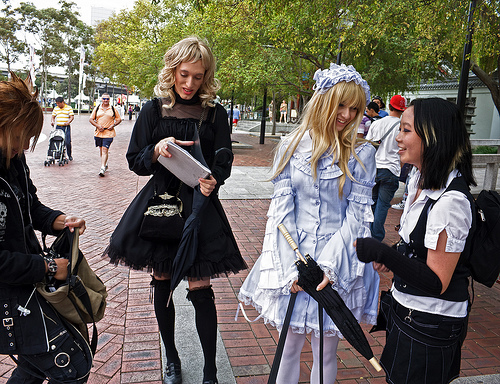

'text: Several dogs are running through the dirt . score: 0.20818138122558594'

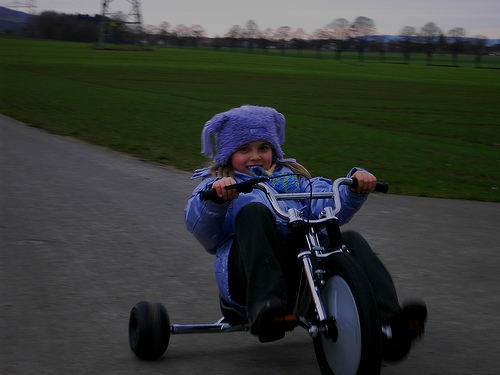

'text: Cyclists are leaping into the air whilst being watched by spectators . score: 0.21022796630859375'

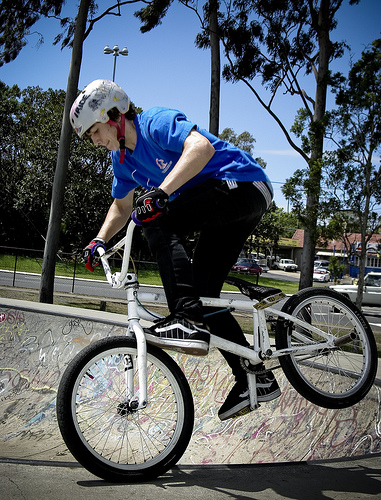

'text: Two men are standing under a large work of art by a brick building . score: 0.28975382447242737'

> This image is unavailable in your country in compliance with local laws


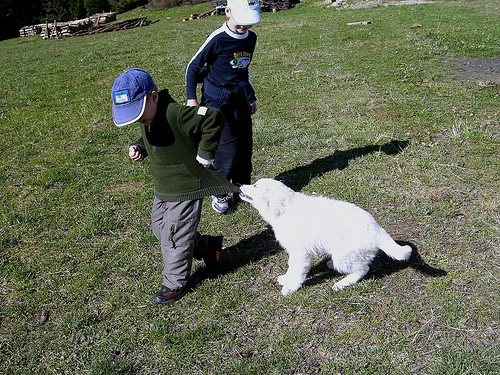

'text: Red boat marked GRAHAM races across water . score: 0.260293185710907'

> This image is unavailable in your country in compliance with local laws


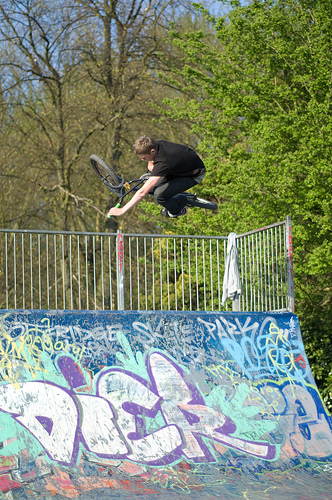

'text: Three dirt bike racers head over a jump . score: 0.24365875124931335'

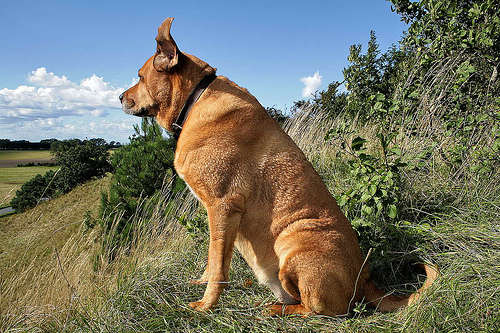

'text: A man playing rugby has the ball and tries to evade a tackler . score: 0.20873919129371643'

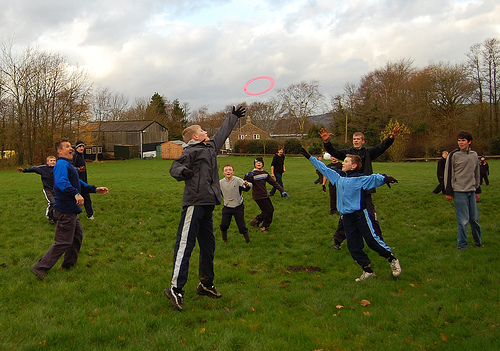

'text: A little white dog in running on the sidewalk . score: 0.247524231672287'

> This image is unavailable in your country in compliance with local laws


In [208]:
for i in range(10):
    image_query(fin_test['query_text'].drop_duplicates().iloc[i])